In [1]:
%matplotlib notebook
%matplotlib inline

import os
os.environ['KERAS_BACKEND'] = "cntk" # you can use "cntk" or "tensorflow"
import time
import datetime as dt
import numpy as np
from numpy import newaxis
from numpy import array
import matplotlib.pyplot as plt
import pandas
from urllib.request import urlretrieve
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using CNTK backend


# Define the TICKER time series to work with

In [2]:
TICKER = "MSFT"

# Create File and Dir paths

In [3]:
SHARE_ROOT = "./stockdemo-model/"

MIN_MAX_DICT = SHARE_ROOT + TICKER +'-min_max.pkl'

# We'll serialize the model in h5 
LSTM_MODEL = SHARE_ROOT + TICKER +'-modellstm.h5'

# and store the weights in h5
MODEL_WEIGHTS = SHARE_ROOT + TICKER +'-modellstm-weights.h5' 

# Load Ticker historical EOD data from Quandl

In [4]:
start_date = "2000-01-01"
end_date =   "2018-04-01"
order = "asc"
parameters = '?&start_date='+start_date+'&end_date='+end_date+'&order='+order
file = TICKER+".csv"

def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + url )
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File is already on disk')

# Download  dataset.
download('https://www.quandl.com/api/v3/datasets/WIKI/' + TICKER + '.csv' + parameters, file)

File is already on disk


In [5]:
data = pandas.read_csv(file, index_col='Date')
# Converting the index as date
data.index = pandas.to_datetime(data.index)

In [6]:
data.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,4586.000000,4586.000000,4586.000000,4586.000000,4.586000e+03,4586.000000,4586.000000,4586.000000,4586.000000,4586.000000,4586.000000,4.586000e+03
mean,40.286633,40.755574,39.826630,40.288769,5.135335e+07,0.003055,1.000218,29.078012,29.373682,28.787272,29.083795,5.799623e+07
std,18.614374,18.899496,18.321689,18.602692,2.875247e+07,0.051648,0.014767,16.089370,16.182702,15.986585,16.094881,3.166583e+07
min,15.200000,15.620000,14.870000,15.150000,5.850800e+06,0.000000,1.000000,12.154701,12.490554,11.890816,12.114718,7.425503e+06
25%,26.696250,26.930000,26.470000,26.690000,3.225230e+07,0.000000,1.000000,19.325016,19.554843,19.091851,19.325016,3.686569e+07
50%,30.300000,30.605000,30.055000,30.320000,4.675009e+07,0.000000,1.000000,22.564576,22.846906,22.354119,22.589808,5.290715e+07
75%,52.655000,53.496250,51.885000,52.735000,6.303825e+07,0.000000,1.000000,32.361858,32.704246,31.917774,32.314573,7.141460e+07
max,117.370000,118.620000,112.250000,116.560000,5.910522e+08,3.080000,2.000000,97.000000,97.240000,96.040000,96.770000,5.910522e+08


In [17]:
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,117.37,118.62,112.00,116.56,26614200.0,0.0,1.0,39.066089,39.482146,37.278708,38.796484,53228400.0
2000-01-04,113.56,117.12,112.25,112.62,27059500.0,0.0,1.0,37.797947,38.982878,37.361920,37.485073,54119000.0
2000-01-05,111.12,116.37,109.37,113.81,32029800.0,0.0,1.0,36.985804,38.733244,36.403324,37.881159,64059600.0
2000-01-06,112.19,113.87,108.37,110.00,27488300.0,0.0,1.0,37.341949,37.901130,36.070479,36.613017,54976600.0
2000-01-07,108.62,112.25,107.31,111.44,31006800.0,0.0,1.0,36.153690,37.361920,35.717662,37.092315,62013600.0


Text(0,0.5,'Volume')

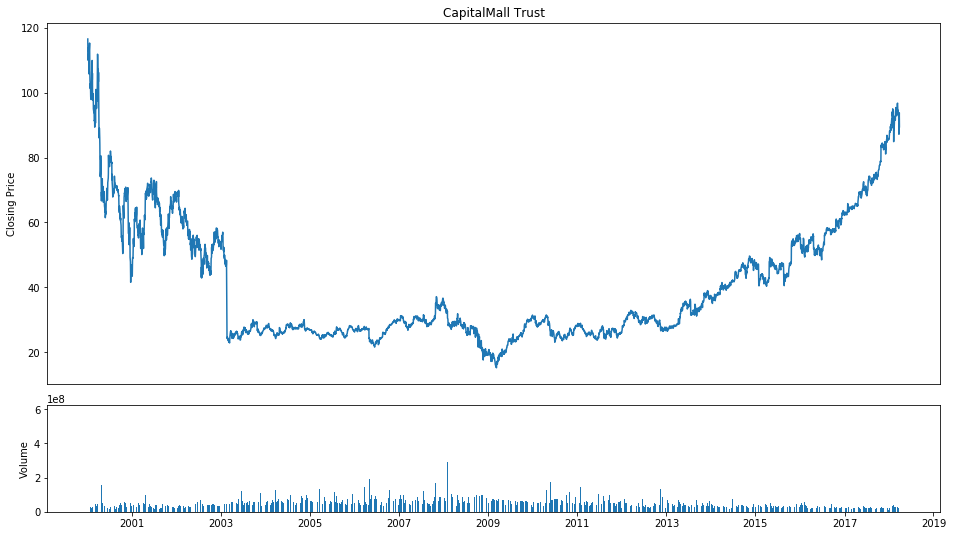

In [8]:
plt.figure(figsize=(16,9))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(data.index, data['Close']) #CMT.index gives the dates
bottom.bar(data.index, data['Volume']) 
 
# set the labels
top.axes.get_xaxis().set_visible(False)
top.set_title('CapitalMall Trust')
top.set_ylabel('Closing Price')
bottom.set_ylabel('Volume')

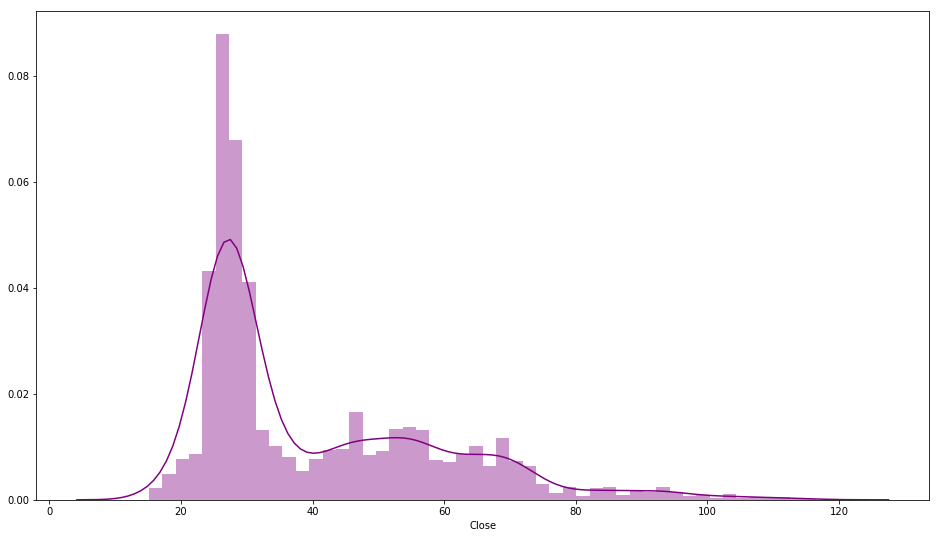

In [9]:
import seaborn as sns
plt.figure(figsize=(16,9))
sns.distplot(data['Close'].dropna(), bins=50, color='purple')

# Data Normalization and Columns pick

In [10]:
def normalize(df):
    result = df.copy()
    min_dict = {}
    max_dict = {}
    
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        max_dict[feature_name] = max_value;
        min_dict[feature_name] = min_value;
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        
    min_max_dict_list = [min_dict, max_dict]
    
    return result, min_max_dict_list

In [26]:
df,  min_max_dict_list = normalize(data.drop(columns=['Adj. Open','Adj. High','Adj. Low','Adj. Volume','Adj. Close', 'Ex-Dividend', 'Split Ratio']))

In [27]:
df = df.astype('float32')

In [28]:
print(min_max_dict_list[0]) # minimum values per column
print(min_max_dict_list[1]) # maximum values per column

{'Volume': 5850800.0, 'Low': 14.87, 'Close': 15.15, 'Open': 15.2, 'High': 15.62}
{'Volume': 591052200.0, 'Low': 112.25, 'Close': 116.56, 'Open': 117.37, 'High': 118.62}


# Add the Target column - X days in the future prediction

In [29]:
shift_days_target = 3

In [30]:
## Add the target (price X days in the future)
df['target'] = df.Close.shift(-shift_days_target)

In [31]:
df.dropna(inplace=True)

In [32]:
df.head(16)

,Open,High,Low,Close,Volume,target
Date,,,,,,
2000-01-03,1.000000,1.000000,0.997433,1.000000,0.035481,0.935312
2000-01-04,0.962709,0.985437,1.000000,0.961148,0.036242,0.949512
2000-01-05,0.938827,0.978155,0.970425,0.972882,0.044735,0.957499
2000-01-06,0.949300,0.953883,0.960156,0.935312,0.036974,0.929100
2000-01-07,0.914358,0.938155,0.949271,0.949512,0.042987,0.893995
2000-01-10,0.961535,0.952136,0.990963,0.957499,0.028419,0.913717
2000-01-11,0.942547,0.957573,0.963442,0.929100,0.029940,0.957499
2000-01-12,0.913184,0.905340,0.919799,0.893995,0.046848,0.987674
2000-01-13,0.872761,0.902913,0.889608,0.913717,0.061041,0.905729


# Function to load/prepare data for modeling

In [35]:
def prepare_data_for_modeling(stock, seq_len):
    data = stock.values #converts to numpy
    result = []
    for index in range(len(data) - seq_len):
        result.append(data[index: index + seq_len])

    result = np.array(result)    
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:,:,:-1] # All rows, all time steps, all feauture minus de last column
    y_train = train[:,-1,-1] # All rows, only the last step, the last column
    x_test = result[int(row):,:,:-1] 
    y_test = result[int(row):,-1,-1]

    return [x_train, y_train, x_test, y_test]

# Function to define the RNN model

In [36]:
def build_model(moving_window, num_features):
        d = 0.3
        model = Sequential()
        model.add(LSTM(96, input_shape=(moving_window, num_features), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, kernel_initializer="uniform", activation="relu"))
        model.add(Dense(1, kernel_initializer="uniform",activation='relu'))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        return model

# Run the model

In [38]:
window = 10
X_train, y_train, X_test, y_test = prepare_data_for_modeling(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (4116, 10, 5)
y_train (4116,)
X_test (457, 10, 5)
y_test (457,)


In [39]:
model = build_model(window,len(X_train[0][0]))

In [40]:
# Verify the architecture 
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 96)                39168     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1552      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 40,737
Trainable params: 40,737
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# checkpoint callback
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_WEIGHTS, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [42]:
# early stop callback
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=200, verbose=1, mode='min')

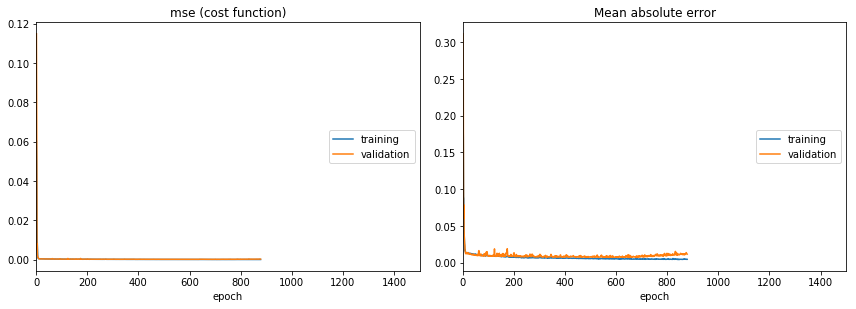


Epoch 00878: val_loss did not improve
Epoch 00878: early stopping
CPU times: user 4min 49s, sys: 5.81 s, total: 4min 55s
Wall time: 4min 55s


In [43]:
%%time
from livelossplot import PlotLossesKeras

#Step 3 Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=1500,
    validation_split=0.1,
    verbose=0,
    callbacks=[PlotLossesKeras(), checkpoint, earlystop])

# Check and plot results

In [44]:
import math

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00035113 MSE (0.01874 RMSE)
Test Score: 0.00026281 MSE (0.01621 RMSE)


In [45]:
#bring the best weights and see test scores again

# load weights into new model
model.load_weights(MODEL_WEIGHTS)
print("Best Weights loaded")

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Best Weights loaded
Train Score: 0.00002807 MSE (0.00530 RMSE)
Test Score: 0.00027719 MSE (0.01665 RMSE)


In [46]:
yhat = model.predict(X_test)

In [47]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

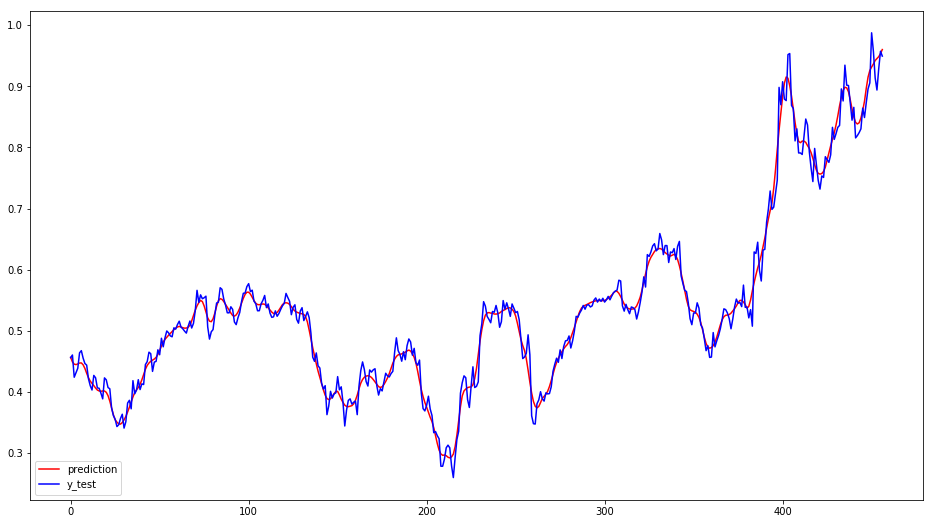

In [48]:
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(yhat,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='lower left')
plt.show()

# Saving the model
The LSTM network is made up of two components, the architecture and the model weights. We already has the best weights loaded, so we now need to save the model and weights together in one h5 file.

In [49]:
import os
    
# save model
model.save(LSTM_MODEL)
print("Model saved")

Model saved


# Saving the MIN and MAX values of each column
We need to save these values max_dict and min_dict into a pickle file, because we are going to need them later in operationalization of the model in order to transfor the realtime data

In [50]:
import pickle

with open(MIN_MAX_DICT, 'wb') as handle:
    pickle.dump(min_max_dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Min-Max values saved")

Min-Max values saved


To test the save operations, we can reload the model files into a test model loaded_model and rescore the test dataset.

In [53]:
from keras.models import load_model

# returns a compiled model
# identical to the previous one
loaded_model = load_model(LSTM_MODEL)
print("Model Loaded")

# Load Min Max list values
with open(MIN_MAX_DICT, 'rb') as handle:
    loaded_min_max_dict_list = pickle.load(handle)

if (min_max_dict_list == loaded_min_max_dict_list):
    print("Min_max List loaded")


Model Loaded
Min_max List loaded


The model constructed from storage can be used to predict

In [54]:
test_row = X_test[:1]
print(test_row)
print(test_row.shape)
score = loaded_model.predict(test_row)
print(score.shape)
print(score)

[[[0.48448664 0.49339807 0.5009242  0.49935904 0.03934645]
  [0.4809631  0.48572814 0.50359416 0.49363968 0.03102522]
  [0.48213762 0.48970875 0.5010269  0.48584953 0.0534228 ]
  [0.4797886  0.47990292 0.5048264  0.48417315 0.04032578]
  [0.46491143 0.47883496 0.48562333 0.48939946 0.04862463]
  [0.45668983 0.47       0.481413   0.47450942 0.04673605]
  [0.45737496 0.46019417 0.4686794  0.4560694  0.06122542]
  [0.43926787 0.45271844 0.45933455 0.46040824 0.08370588]
  [0.43163356 0.43796116 0.44393098 0.4240213  0.04528219]
  [0.42791426 0.42640775 0.4448552  0.4312198  0.03904126]]]
(1, 10, 5)
(1, 1)
[[0.45657307]]


# So, where to go from here?

Well, as you can imagine, this is a simple MANY-TO-ONE prediction. The model is predicting the next Time Step by getting as input a window (sequence) of past measures.
This model can be improved by:
    1. Making the series stationary and using StandardScaler vs MaxMinScaler
    2. Predicting the next N steps (multi-step prediction) by using seq2seq models vs a simple RNN (like above)
    3. And the most important of all: Adding more signals/features/columns
